In [15]:
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


PATH = "/home/andre/Documents/Git/VISAO_ROBOTICA_EGM0008/04_CALIBRACAO_DE_CAMERA/"
PATH_IMG = "/home/andre/Documents/Git/VISAO_ROBOTICA_EGM0008/IMAGENS/"

print(PATH)
print(os.listdir())
print(cv.__version__)

img_original = cv.imread(PATH_IMG+os.listdir(PATH_IMG)[2])
img_gray = cv.cvtColor(img_original, cv.COLOR_BGR2GRAY)

def cm_to_inch(value):
    return value/2.54

def rad_to_angle(value):
    return value*180/np.pi

def angle_to_rad(value):
    return value*np.pi/180

/home/andre/Documents/Git/VISAO_ROBOTICA_EGM0008/04_CALIBRACAO_DE_CAMERA/
['carrinho.jpg', 'Einstein.png', 'everest.jpg', 'fabio.png']
4.10.0


# Aumento de brilho

Adição dos valores dos pixels por uma constante. Lembrando que pode dar _Overflow_ caso soma de maneira bruta, a soma deve ser o máximo e o mínimo valor dos pixels, 255 e 0 respectivamente.
<br>
<br>
A função **cv2.add(IMG, constante)** já faz essa tranbicagem.

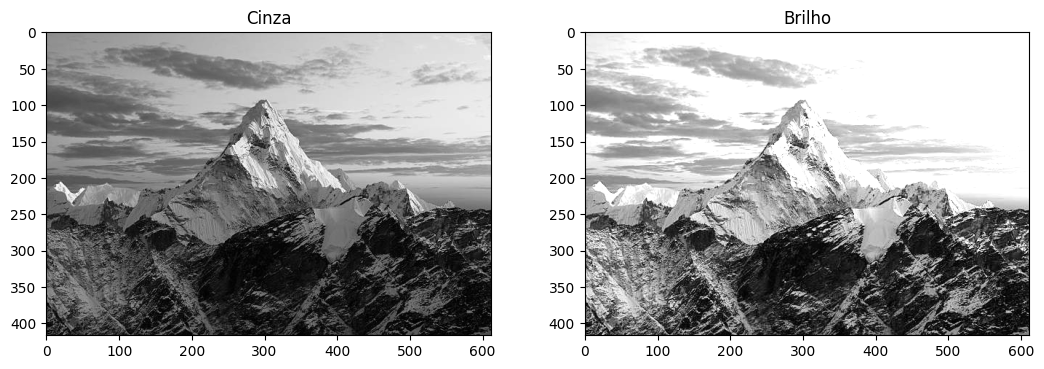

In [16]:
img_brilho = cv.add(img_gray, 100)

plt.figure(figsize=(cm_to_inch(50), cm_to_inch(10)))
plt.subplot(132), plt.imshow(img_gray, cmap='gray'), plt.title('Cinza')
plt.subplot(133), plt.imshow(img_brilho, cmap='gray'), plt.title('Brilho')
plt.show()

# Alargamento de Contraste

$ s = \frac{L}{1 + \exp^{-k \cdot (r - r_0)}}$

<br>

* $L$: Valor Máximo dos pixels;
* $k$: constante para o contraste (valor pequeno);
* $r$: Valor do pixel naquela coordenada;
* $r_0$: Valor médio da curva.

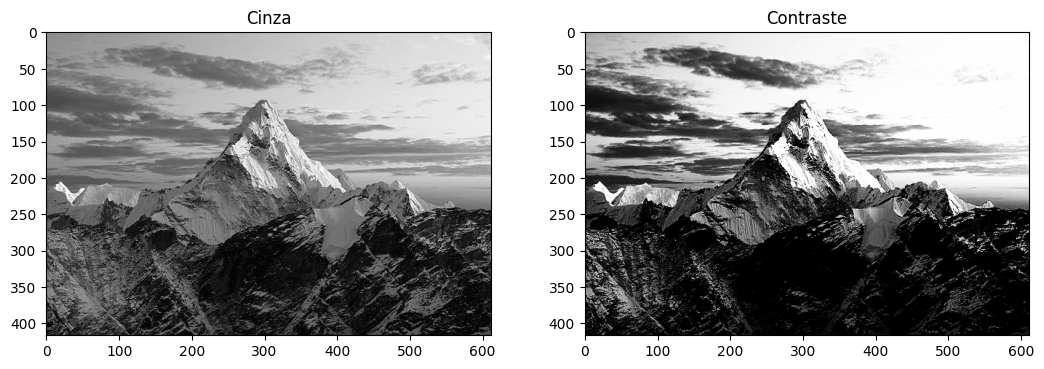

In [17]:
def Alargamento_de_contraste(img, L=255, r0=128, k=0.01):
    img_dest = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_dest[i,j] = L/(1+np.exp(-k*(np.float16(img[i,j])-r0)))
            # nao esquecer de converter o valor da img para float

    return img_dest

img_contraste = Alargamento_de_contraste(img_gray, k=0.05)

plt.figure(figsize=(cm_to_inch(50), cm_to_inch(10)))
plt.subplot(131), plt.imshow(img_gray, cmap='gray'), plt.title('Cinza')
plt.subplot(132), plt.imshow(img_contraste, cmap='gray'), plt.title('Contraste')
plt.show()

del img_contraste

# Negativo

$Img_{negativa} = L - 1 - r$
<br>

* $L$: Quantidade de valores que o pixel pode ter (256)
* $r$: Valor do pixel na imagem Original.


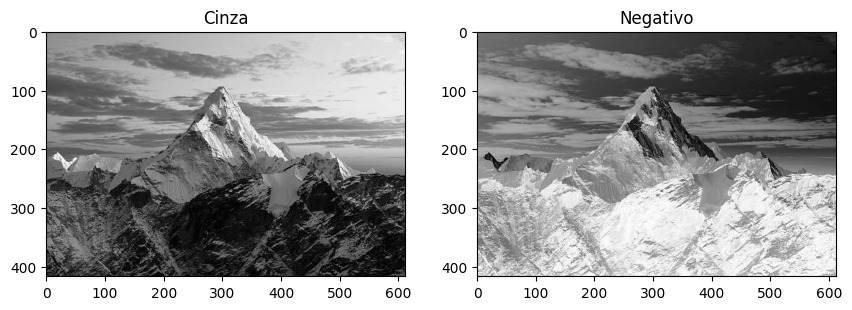

In [35]:
def negativo(img_gray, L):
    img_temp = np.zeros_like(img_gray)

    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            img_temp[i][j] = L - 1 - img_gray[i][j]

    return img_temp


img_negativo = negativo(img_gray=img_gray, L=256)

# De maneira preguicosa de python
#img_negativo = 255 - img_gray

plt.figure(figsize=(cm_to_inch(40), cm_to_inch(10)))
plt.subplot(131), plt.imshow(img_gray, cmap='gray'), plt.title('Cinza')
plt.subplot(132), plt.imshow(cv.cvtColor(img_negativo, cv.COLOR_BGR2RGB)), plt.title('Negativo')

plt.show()

del img_negativo

# Limiarização (_Trhesholding_)

Cria uma imagem binária com base no valores dos pixels:
<br>

se $img[i][j]$ > limiar: $img[i][j] = 255$
<br>
se não: $img[i][j] = 0$

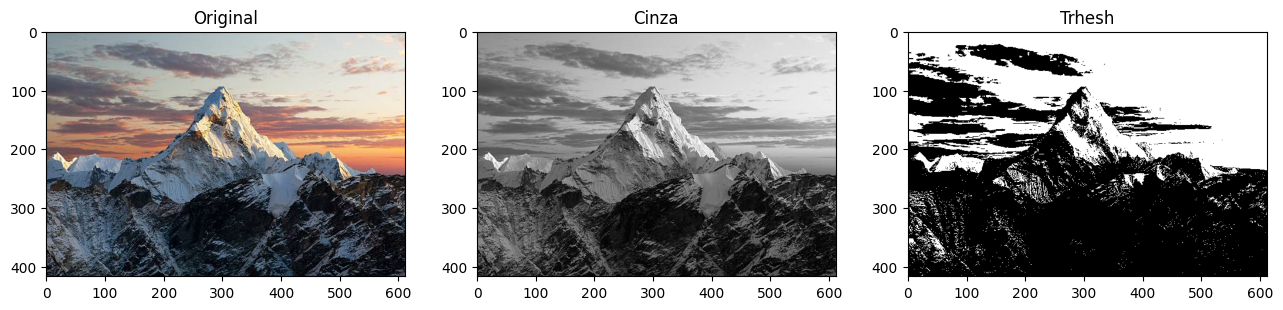

In [18]:
# img_thresh = cv.threshold(img_gray, 128, 255, cv.THRESH_BINARY)[1]

def thresholding(img, limiar):
    img_dest = np.zeros_like(img)

    if img_dest.ndim == 3:
        img_dest[img > limiar][:] = 255
        img_dest[img < limiar][:] = 0
    else:
        img_dest[img > limiar] = 255
        img_dest[img < limiar] = 0

    return img_dest

img_thresh = thresholding(img_gray, 128)

plt.figure(figsize=(cm_to_inch(40), cm_to_inch(10)))
plt.subplot(131), plt.imshow(cv.cvtColor(img_original, cv.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(img_gray, cmap='gray'), plt.title('Cinza')
plt.subplot(133), plt.imshow(img_thresh, cmap='gray'), plt.title('Trhesh')
plt.show()

(1960, 2948, 3)


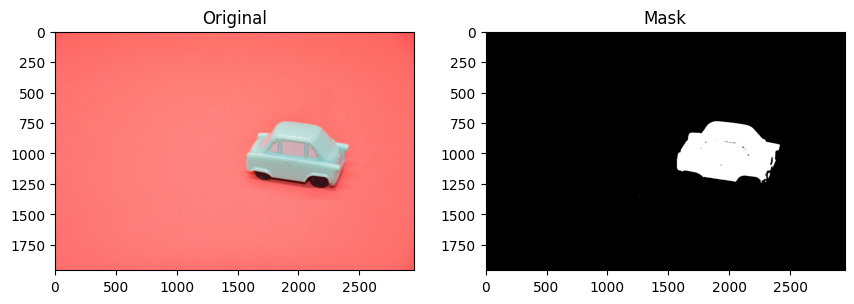

In [19]:
img_carrinho = cv.imread(os.listdir()[0])
print(img_carrinho.shape)

img_carrihno_mask = cv.inRange(img_carrinho, (150,150,128), (255,255,255))

plt.figure(figsize=(cm_to_inch(40), cm_to_inch(10)))
plt.subplot(131), plt.imshow(cv.cvtColor(img_carrinho, cv.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(img_carrihno_mask, cmap='gray'), plt.title('Mask')

plt.show()

997.5433548369737 1982.5576293077352


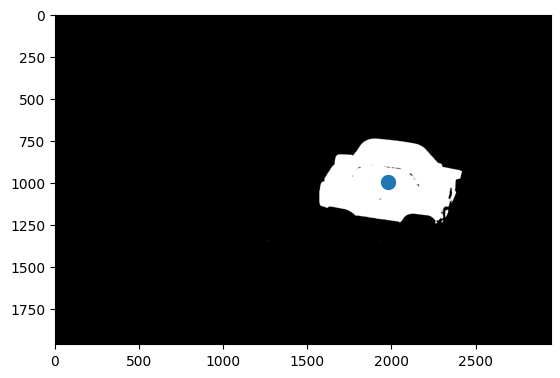

In [20]:
soma_x = 0
soma_y = 0
cont = 0
for i in range(img_carrihno_mask.shape[0]):
    for j in range(img_carrihno_mask.shape[1]):
        if img_carrihno_mask[i,j] == 255:
            soma_x += i
            soma_y += j
            cont += 1

c_x = soma_x / cont
c_y = soma_y / cont

print(c_x, c_y)

plt.imshow(img_carrihno_mask, cmap='gray')
plt.scatter(c_y, c_x, linewidths=5)

plt.show()

# Transformação Geométrica

## Warp Linear


### Warp Afim


$Imagem = A^{-1} \cdot(Imagem - b)$

* $A^{-1}$: Matriz que junta a escala com a de rotação (colocar a matriz)
* $b$: Vetor coluna $[[x],[y]]$ para realizar a translação

(417, 612, 3)


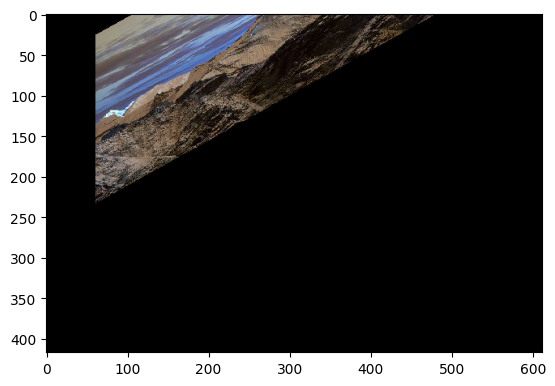

In [22]:
def warp(img, A, b):
    img_dest = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            coord = np.array([[i], [j]])
            coord_dest = np.linalg.inv(A) @ (coord - b)

            x = coord_dest[0,0]
            y = coord_dest[1,0]

            if x >= 0 and x < img.shape[0]-1 and y >= 0 and y < img.shape[1]-1:
                img_dest[i,j] = img[int(x), int(y)]

    return img_dest

print(img_original.shape)

img_warp = warp(img_original, [[0.5, -0.50],[0, 0.9]], [[25],[61]])

plt.imshow(img_warp)

plt.show()